<center><img src="http://what-when-how.com/wp-content/uploads/2012/07/tmp26dc139_thumb.png" width=50% > </center>

# <center> Assignment 2: Neighborhood Processing & Filters </center>
<center> Computer Vision 1 University of Amsterdam </center>
    <center> Due 23:59PM, September 24, 2022 (Amsterdam time) </center>
    
***

##(100 pts)

## General guidelines
Your code and discussion must be completed in this **jupyter notebook** before the deadline by submitting it to the Canvas Lab 2 Assignment. Submit your assignment in a **zip file**, with all the relevant files and images need to run your notebook. Name your zip file as follows:  **StudentID1_StudentID2_StudentID3.zip**
For full credit, make sure you follow these guidelines:

- Make sure you use the provided python environment. You can create the environment using conda and the provided YAML file using the following command: `conda env create --file=CV1_env.yaml`, then activate it as `conda activate cv1`. Using different packages versions may result in the impossibility to run the submitted code and therefore in the subtraction of points. Below you will find a code cell to check the versions of your packages. 
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make your notebook self-contained and complete.
- Analyze your results and discuss them, e.g. why algorithm A works better than algorithm B in a certain problem.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.
- Make sure all the code in your notebook runs without errors or bugs before submitting. Code that does not run can result in a lower grade. 

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.
Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations.

In [22]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import sklearn
from sklearn.decomposition import PCA
from scipy import signal as sp
import requests


In [2]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "3.4.2", "You're not using the provided Python environment!"
assert np.__version__ == "1.19.5", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.3.4", "You're not using the provided Python environment!"
assert sklearn.__version__ == "0.23.0"

# Proceed to the next cell only if you don't get any error.


# 1 Introduction 


In this assignment, you will get familiar with fundamentals of neighborhood processing for image processing. These techniques allow for low-level image understanding via extraction of structural patterns such as edges and blobs. Similarly, they find an extensive use in image denoising and higher level image reasoning such as shape recognition. Moreover, neighborhood or block processing is one of the key components of *Convolutional Neural Networks*. Therefore, a good understanding of these
procedures will be a stepping stone towards understanding more complex machinery used in computer vision and machine learning.

In subsequent sections of this assignment, we will first explain neighborhood processing and introduce low-level filters commonly used to analyze images. After that, we will see how these mathematical concepts relate to practice by working through fundamental tasks such as denoising and segmentation. By the end of this assignment, you will have an overall understanding of the following:
* Gaussian and Gabor filters
* Edge detection and image denoising
* Texture-based image segmentation


---


First we need two helper functions 

In [3]:
### Use this for the last exercise
'''
Loads an image, resizes image with proper resize factor and sets proper color representation
:param image_id: id of an image: Kobi, Polar, Robin-1, Robin-2, Cows, SciencePark
:return: image
'''
def load_image(image_id: str='Polar'):
    if image_id == 'Kobi':
        img = cv2.imread('./sample_data/kobi.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_factor = 0.25
    elif image_id == 'Polar':
        img = cv2.imread('./sample_data/polar-bear-hiding.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_factor = 0.75
    elif image_id == 'Robin-1':
        img = cv2.imread('./sample_data/robin-1.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_factor = 1
    elif image_id == 'Robin-2':
        img = cv2.imread('./sample_data/robin-2.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_factor = 0.5
    elif image_id == 'Cows':
        img = cv2.imread('./sample_data/cows.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_factor = 0.5
    elif image_id == 'SciencePark':
        img = cv2.imread('./sample_data/sciencepark.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_factor = 0.2
    else:
        raise ValueError('Image not available.')
        
    img = cv2.resize(img, (0, 0), fx=resize_factor, fy=resize_factor)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


    return img

In [4]:
'''Displays image in grey scale'''
def show_image(image, image_title:str= "Polar", cmap='gray'):
    plt.figure()
    plt.title(image_title)
    plt.imshow(image, cmap=cmap)
    plt.axis("off")

# 2 Neighborhood Processing


Neighborhood processing is simply about looking around a point $I(x, y)$ (i.e. pixel) in the image, $I$, and applying a function, $h(k, l)$, which measures certain properties or relationships between the pixels in that localized window. The function, $h(k, l)$, is generally referred to as the neighborhood operator or local operator. One of the most common forms of a neighborhood operator is a linear filter. Linear filters simply compute the weighted sum of neighboring pixel intensities and assign it to the pixel of interest (output $I_{out}(i, j)$). The filters in which we are interested here are usually represented as a square matrix.

---
**Hint**: Filters, kernels, weight matrices or masks are interchangeably used in the literature. A kernel is a matrix with which we describe a neighborhood operation. This operation can, for example, be edge detection or smoothing.

---

Linear filters are shifted over the entire image plane via operators such as correlation ($\otimes$) and convolution ($\ast$). Both of these operators are *linear shift-invariant* (LSI) implying that the filters behave the same way over the entire image. Discrete forms of these operators are given in the following:


Correlation (1):
<center>
$\mathbf{I}_{out} = I \otimes  \mathbf{h}\\
 \mathbf{I}_{out}(i,j) = \sum_{k,l}  \mathbf{I}(i+k,j+l) \mathbf{h}(k,l)$
</center>
Convolution (2):
<center>
$    \mathbf{I}_{out} = \mathbf{I} \ast  \mathbf{h}\\
 \mathbf{I}_{out}(i,j) = \sum_{k,l} \mathbf{I}(i-k,j-l) \mathbf{h}(k,l)$
 </center>


---
The following example illustrates the overall idea of neighborhood processing. The kernel or the mask convolves over the input image. In the case of linear filters, this is simply multiplying each pixel intensity with the corresponding weight in the kernel (see the yellowish $7x7$ window where the kernel is placed). In the example, the kernel is $7x7$ averaging mask. You can see its effect by comparing the red (before filtering) and the green (after filtering) frames.





**Example:**
![](https://drive.google.com/uc?export=view&id=1HXt-WTi2Mg-jHYU4tvcKl4R29gi-g1QY)

### Question (10 pts)
1.   What is the difference between correlation and convolution operators? How do they treat the signals $\mathbf{I}$ and $\mathbf{h}$?
2.   Correlation and convolution operators are equivalent when we make an assumption on the form of the mask $\mathbf{h}$. Can you identify the case?


YOUR ANSWER HERE

# 3 Low-level filters


In this section, you will design common linear filters used in neighborhood processing. We will focus in particular on Gaussian and Gabor filters.

## 3.1 Gaussian Filters

### 3.1.1 1D Gaussian Filter



The 1D  Gaussian filter is defined as follows:
<center>
$ G_{\sigma}(x)=\frac{1}{\sigma\sqrt{2\pi}}\text{ exp}(-\frac{x^2}{2\sigma^2}),$
</center>
where $\sigma$ is the variance of the Gaussian. However, such formulation creates an infinitely large convolution kernel. In practice, the kernel is truncated with a `kernel_size` parameter such that $-\left\lfloor \frac{kernel\_size}{2}\right\rfloor \leq x \leq \left\lfloor \frac{kernel\_size}{2} \right\rfloor$, where $\left\lfloor . \right\rfloor$ is the floor operator. As an example, if `kernel_size` equals 3, $x \in \{ -1, 0, 1 \} $.

### Exercise 
Now, implement the following *gauss1D* function.

**Hint:** 
Do not forget to normalize your filter.

**Note:** You are not allowed to use a Python built-in function provided by *SciPy* or other libraries to compute the kernel.

In [5]:
def gauss1D(sigma, kernel_size):
    G = np.zeros((1, kernel_size))
    if kernel_size % 2 == 0:
        raise ValueError('kernel_size must be odd, otherwise the filter will not have a center to convolve on')
    
    G = np.fromfunction(lambda x: np.exp((-1*(x-(kernel_size-1)/2)**2) / (2*sigma**2)), (kernel_size,))
    
    G = G/np.sum(G)
    return G

In [6]:
# Run this to test your function:
assert np.all(np.round(gauss1D(2,5), 4) == [0.1525, 0.2218, 0.2514, 0.2218, 0.1525]) # check if values are close enough if assert gives error

### 3.1.2 2D Gaussian Filter



One of the most important properties of 2D Gaussian kernels is separability. Therefore, convolving an image with a 2D Gaussian is equivalent to convolving
the image twice with a 1D Gaussian filter, once along the x-axis and once along the y-axis **separately**. A 2D Gaussian kernel can then be defined as a product of two 1D Gaussian kernels:
<center>
$
G_{\sigma}(x, y) = G_{\sigma}(x) \times G_{\sigma}(y)$ *(Eq. A)*

$
 = \frac{1}{\sigma^2 2\pi}\text{ exp}(-\frac{x^2 + y^2}{2\sigma^2})
 $ *(Eq. B)*
 </center>

### Exercise 

Implement `gauss2D` function that corresponds to *Eq. A* (not *Eq. B*) and you should make use of `gauss1D`.

**Note:** Again, you are not allowed to use a Python built-in function provided by *SciPy* or other libraries to compute the kernel.

In [7]:
def gauss2D(sigma_x, sigma_y, kernel_size):
# solution
    Gx = gauss1D(sigma_x, kernel_size).reshape((3,1))
    Gy = gauss1D(sigma_y, kernel_size).reshape((1,3))
    
    G = Gx @ Gy
    print("Gx: {n}".format(n=Gx))
    print("Gy: {n}".format(n=Gy))
    return G



In [8]:
# Run this to test your function:
assert np.all( np.round(gauss2D(2, 2, 3) , 4) == 
       [[0.1019, 0.1154, 0.1019],
       [0.1154, 0.1308, 0.1154],
       [0.1019, 0.1154, 0.1019]])

Gx: [[0.31916777]
 [0.36166446]
 [0.31916777]]
Gy: [[0.31916777 0.36166446 0.31916777]]


### Question (5pts)
What is the difference between convolving an image with (1) a 2D Gaussian kernel and (2) a 1D Gaussian kernel in the x- and y-direction? Will the result be the same? What is their computational complexity?

### Answer

The Gaussian kernel is separable, which means that it can be computed as the product of two simpler Gaussian filters. This means that the result of convolving an image with a 2D Gaussian kernel will be the same as convolving it with a 1D Gaussian kernel in the x- and y- directions.

To carry out a convolution between an image of size $N$x$N$, and a 2D Gaussian filter of size $M$x$M$, you need 4 for loops. 2 for loops to iterate through each pixel in the image, and 2 for loops to perform the 2D convolution at each pixel. This gives a computational complexity of $O(N^2M^2)$. 

When performing a convolution with a 1D Gaussian kernel, you get a reduced computational complexity of $O(N^2M)$ with the following approach. First, to generate an intermediate image, compute the 1D convolution of the $N$x1 column with the $M$x1 kernel, and repeat the process for N columns.

Then, for the intermediate image, compute the 1D convolution of the 1x$N$ row with the 1x$M$ kernel, and repeat for N rows. This will require approximately $2 * N^2 * M$ MACs, or an $O(N^2M)$ computational complexity.

### 3.1.3 Gaussian Derivatives
So far the Gaussian kernels that we computed are mainly targeted to image enhancement algorithms (e.g. denoising an image). These kernels can also be used for detecting changes in the image intensity pixels. These low-level features can then further be used as building blocks for more complicated tasks like object detection or segmentation.


Concretely, the  first order derivative of the 1D Gaussian kernel is given by:

<center>
$
\frac{d}{dx}G_\sigma(x)  =\frac{d}{dx}\left( \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{x^2}{2\sigma^2}) \right )$

$
 = -\frac{x}{\sigma^3\sqrt{2\pi}}\exp(-\frac{x^2}{2\sigma^2})$ 
*(Eq. C)*

 $
 = -\frac{x}{\sigma^2}G_\sigma(x)
 $
</center>
Similarly, the first order derivative of the 2D Gaussian kernel can be obtained by computing $\frac{d}{dx}G_\sigma(x,y)$ and $\frac{d}{dy}G_\sigma(x,y)$.

#### Question (5pts)
A second order derivative of the Gaussian kernel can also be computed. Why
is it interesting to design a second order kernel?

### Answer

We can use the second order kernel for edge detection or blob detection (by highlighting), as the first order filter will help to remove all the noises and smooth the image, then the areas within the contours in an image will "disapear" after applying the second order kernel as the values in these areas do not vary much from one another. The only left variantions that can result non-zero values after the second order kernel are the edges where the values of the pixels change sharply around, hence, the edges will become highlighted after the second order kernel.


## 3.2 Gabor filters


Gabor filters fall into the category of linear filters and are widely used for *texture analysis*. The reason why they are a good choice for texture analysis is that they localize well in the frequency spectrum (*optimally* bandlimited) and therefore work as flexible *band-pass* filters.

In the following image you can see even (cosine-modulated) and odd parts (sine-modulated) of Gabor filters with fixed-σ Gaussian. You can observe time-domain filters for the modulating sinusoidals of central frequencies, 10, 20, 30, 40 and 50 Hz, respectively.


![](https://drive.google.com/uc?export=view&id=1wv6ZUOfiHMDgg0jW7n5lqkaFiFztjnEo)

Gabor filters with varying center frequencies are sensitive to different
frequency bands. Notice that the neighboring (in the frequency spectrum) filters minimally interfere with each other.

![](https://drive.google.com/uc?export=view&id=1hUQaKE_TwC-9_jMIao1CCxyjembMrUab)

### 3.2.1 1D Gabor Filters

For the sake of simplicity, we start by studying what a Gabor function is using 1D signals (e.g. speech). The idea will later be generalized to the 2D case, which is suited for our primary interest, images. A Gabor function is a Gaussian function modulated with a complex sinusoidal carrier signal. Let us denote the Gaussian with $x(t)$ and complex sinusoidal with $m(t)$. Then, a Gabor function $g(t)$ can be formulated by:

$
g(t) = x(t) m(t)   
$ *(Eq. D)*

where $x(t) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{t^2}{2\sigma^2}}$ and $m(t)=e^{j 2 \pi f_c t} = e^{j w_c t}$. $\sigma$ is the parameter determining the spread of the Gaussian and $w_c$ is the central frequency of the carrier signal.


---


**Hint:**
A complex sinusoidal can be represented as follows using the *Euler's formula*:
$e^{jwt} = \cos(wt) + j\sin(wt)$


---



Using Euler's formula, we get the following:
\begin{align}
    g(t) &= x(t)m(t) \\
    g(t) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{t^2}{2\sigma^2}} e^{j w_c t} \\
    g(t) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{t^2}{2\sigma^2}} [\cos(w_c t) + j\sin(w_c t)]
\end{align}
We can further arrange the terms and arrive at the following form
\begin{align}
    g(t) = g_e(t) + jg_o(t)
\end{align}
where $g_e(t)$ and $g_o(t)$ are the even and odd parts arranged orthogonally on the complex plane $\mathbf{Z}^2$. In practice, one can use either the even or the odd part for filtering purposes (or one can use the complex form).  

### 3.2.2 2D Gabor Filters


The Gabor filters can also be defined in 2D as well. The main difference lies in the dimensionality of the signals (i.e. carrier and gaussian). A sine wave in 2D is described by two orthogonal spatial frequencies $u_0$ and $v_0$ such that it is given as $s(x,y) = sin(2\pi(u_0 x + v_0 y))$ where a 2D gaussian is simply $C e^{-(\frac{(x-x_0)^2}{2\sigma_x^2}) + \frac{(y-y_0)^2}{2\sigma_y^2})}$ with $C$ being a normalizing constant. 2D Gabor function then takes the following forms in the real and complex parts:

\begin{align}
    g_{real}(x,y; \lambda, \theta, \psi, \sigma, \gamma) = \exp\left(-\frac{x^{\prime2}+\gamma^2 y^{\prime2}}{2\sigma^2}\right)
\cos\left( 2\pi \frac{x^{\prime}}{\lambda} + \psi  \right)                                              
\end{align}
\begin{align}
g_{im}(x,y; \lambda, \theta, \psi, \sigma, \gamma) &= \exp\left(-\frac{x^{\prime2}+\gamma^2 y^{\prime2}}{2\sigma^2}\right)
\sin\left( 2\pi \frac{x^{\prime}}{\lambda} + \psi  \right)
\end{align}

where
\begin{align}
    x^\prime &= x\cos\theta + y\sin\theta \\
    y^\prime &= -x\sin\theta + y\cos\theta
\end{align}

####Question 4 (5pts)
Conduct a self-study on the Gabor filters. Explain shortly what the parameters $\lambda, \theta, \psi, \sigma, \gamma$ control.

YOUR ANSWER HERE

###Exercise 

##### Design array of Gabor Filters

Now, you will create a Gabor Filterbank. A filterbank is a collection of filters with varying properties (e.g. {shape, texture}). A Gabor filterbank consists of Gabor filters of distinct orientations and scales. We will use this bank to extract texture information from the input image. 

Your task is to implement function `createGabor` but to do that you will need some helper functions, which are defined below. Finish the implementation of those and then use them in `createGabor`.

In [9]:
def generateRotationMatrix(theta):
  # Returns the rotation matrix. 
  # Hint: https://en.wikipedia.org/wiki/Rotation_matrix
  
  rotMat = ...  # TODO: code the rotation matrix which fits gabor equation given theta. 
  return rotMat


In [10]:
def createCos(rot_x, lamda, psi):
  # Returns the 2D cosine carrier. 
  
  cosCarrier = ...  # TODO: Implement the cosine given rot_x, lamda and psi.

  # Reshape the vector representation to matrix.
  cosCarrier = np.reshape(cosCarrier, (np.int32(np.sqrt(len(cosCarrier))), -1))
  return cosCarrier

In [11]:
def createSin(rot_x, lamda, psi):
  # Returns the 2D sine carrier. 
  
  sinCarrier = ...  # TODO: Implement the sine given rot_x, lamda and psi.

  # Reshape the vector representation to matrix.
  sinCarrier = np.reshape(sinCarrier, (np.int32(np.sqrt(len(sinCarrier))), -1))
  return sinCarrier

In [12]:
def createGauss(rot_x, rot_y, gamma, sigma):
  # Returns the 2D Gaussian Envelope. 
  
  gaussEnv = ...  # TODO: Implement the Gaussian envelope.


  return gaussEnv

Implement the function `createGabor` using above helper functions and equations for $g_{real} $ and $g_{im}$. 


In [13]:
def createGabor(sigma, theta, lamda, psi, gamma):
	'''
	Creates a complex valued Gabor filter.
	myGabor = createGabor(sigma, theta, lamda, psi, gamma) generates Gabor kernels. 
	:param sigma: Standard deviation of Gaussian envelope.
	:param theta: Orientation of the Gaussian envelope. Takes arguments in the range [0, pi/2).
	:param lamda: The wavelength for the carriers. The central frequency (w_c) of the carrier signals.
	:param psi: Phase offset for the carrier signal, sin(w_c . t + psi).
	:param gamma: Controls the aspect ratio of the Gaussian envelope
	:return: myGabor - A matrix of size [h,w,2], holding the real and imaginary 
						parts of the Gabor in myGabor(:,:,1) and myGabor(:,:,2), respectively.
	'''
							
	# Set the aspect ratio.
	sigma_x = sigma
	sigma_y = float(sigma)/gamma

	# Generate a grid
	nstds = 3
	xmax = max(abs(nstds*sigma_x*np.cos(theta)),abs(nstds*sigma_y*np.sin(theta)))
	xmax = np.ceil(max(1,xmax))
	ymax = max(abs(nstds*sigma_x*np.sin(theta)),abs(nstds*sigma_y*np.cos(theta)))
	ymax = np.ceil(max(1,ymax))

	# Make sure that we get square filters. 
	xmax = max(xmax,ymax)
	ymax = max(xmax,ymax)
	xmin = -xmax 
	ymin = -ymax

	# Generate a coordinate system in the range [xmin,xmax] and [ymin, ymax]. 
	[x,y] = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))

	# Convert to a 2-by-N matrix where N is the number of pixels in the kernel.
	XY = np.concatenate((x.reshape(1, -1), y.reshape(1, -1)), axis=0)

	# Compute the rotation of pixels by theta.
	# Hint: Create appropriate rotation matrix to compute the rotated pixel coordinates: rot(theta) * XY.
	rotMat = generateRotationMatrix(theta)
	rot_XY = np.matmul(rotMat, XY)
	rot_x = rot_XY[0,:]
	rot_y = rot_XY[1,:]


	# Create the Gaussian envelope.
	# IMPLEMENT the helper function createGauss above.
	gaussianEnv = createGauss(rot_x, rot_y, gamma, sigma)

	# Create the orthogonal carrier signals.
	# IMPLEMENT the helper functions createCos and createSin above.
	cosCarrier = createCos(rot_x, lamda, psi)
	sinCarrier = createSin(rot_x, lamda, psi)

	# Modulate (multiply) Gaussian envelope with the carriers to compute 
	# the real and imaginary components of the complex Gabor filter. 
	myGabor_real = ...  # TODO: modulate gaussianEnv with cosCarrier
	myGabor_imaginary = ...  # TODO: modulate gaussianEnv with sinCarrier

	# Pack myGabor_real and myGabor_imaginary into myGabor.
	h, w = myGabor_real.shape
	myGabor = np.zeros((h, w, 2))
	myGabor[:,:,0] = myGabor_real
	myGabor[:,:,1] = myGabor_imaginary

	# Uncomment below lines from "fig = plt.figure()" to see how are the gabor filters
	# figure
	# subplot(121), imshow(myGabor_real,[])
	# subplot(122), imshow(myGabor_imaginary, [])

	# fig = plt.figure()
	# ax = fig.add_subplot(1, 2, 1)
	# ax.imshow(myGabor_real)    # Real
	# ax.axis("off")
	# ax = fig.add_subplot(1, 2, 2)
	# ax.imshow(myGabor_imaginary)    # Real
	# ax.axis("off")

	return myGabor



#### Question (5pts)
Visualize how the parameters $\theta$, $\sigma$ and $\gamma$ affect the filter in spatial domain. 

YOUR ANSWER HERE

# 4 Applications in image processing 

## 4.1 Noise in digital images

The quality of digital images can be affected in different ways. For example, the
acquisition process can be very noisy and with a low-resolution (e.g. some medical
imaging modalities only generate a 128x128 image). Noise can also come from the
user who set wrong parameters on the digital camera. Consequently, different computer vision algorithms are required to enhance noisy or corrupted images. With the
growing amount of photos taken every day, image enhancement has then become a
very active area of research.

In this section, we only focus on simple algorithms to correct noise coming typically from the sensor of your camera. Many other types of noise or corruption can happen but are out of the scope of this assignment.

### 4.1.1 Salt-and-pepper noise

Noise can also occur with over-exposition causing a ”hot” pixel or with a defective
sensor causing a ”dead” pixel. This is called salt-and-pepper noise. Pixels in the
image are randomly replaced by either a white or black pixel.

### 4.1.2 Additive Gaussian noise

Noise also occurs frequently when the camera heats up. This is called thermal noise
and this can be modeled as an additive Gaussian noise. Every pixel in the image
has a noise component that corresponds to a random value chosen independently
from the same Gaussian probability distribution. The Gaussian distribution has a
mean of 0 and its standard deviation corresponds to a parameter.

\begin{equation}
\begin{array}{rl}
\mathbf{I}^{\prime}(x) = \mathbf{I}(x) + \epsilon \text{, where } \epsilon \sim  \mathcal{N}(0, \sigma^2)
\end{array}
\end{equation}

where $\mathbf{I}^{\prime}$ is the noisy image and $\mathbf{I}$ is the original image without any noise $\epsilon$.

## 4.2 Image denoising

### 4.2.1 Quantitative evaluation

The peak signal-to-noise ratio (PSNR) is a commonly used metric to quantitatively evaluate the performance of image enhancement algorithms. It is derived from the mean squared error (MSE):

\begin{equation}
\begin{array}{rl}
MSE = \frac{1}{m \cdot n}\sum\limits_{x,y}\Big[\mathbf{I}(x,y) - \mathbf{\hat{I}}(x,y)\Big]^2
\end{array}
\end{equation}
where $\mathbf{I}$ is the original image of size $m\times n$ and $\mathbf{\hat{I}}$ its approximation (i.e. in our case an enhanced corrupted image). The PSNR corresponds to:

\begin{equation}
\begin{split}
PSNR & = 10 \cdot \log_{10} \Big(\frac{\mathbf{I}_{max}^2}{MSE}\Big) \\
 & = 20 \cdot \log_{10} \Big(\frac{\mathbf{I}_{max}}{\sqrt{MSE}}\Big) \\
 & = 20 \cdot \log_{10} \Big(\frac{\mathbf{I}_{max}}{RMSE}\Big)
\end{split}
\end{equation}
where $\mathbf{I}_{max}$ is the maximum pixel value of $\mathbf{I}$ and RMSE is the root of the MSE.



###Exercise

Implement **myPSNR**

**Note:** You are not allowed to use the Python built-in functions provided in *PIL* and *Skimage*.

In [14]:
def myPSNR(orig_image, approx_image):
  """
  ================
  Your code here
  ================
  """
  return PSNR

### Questions (10 pts)
1.   Explain briefly in your own words what the PSNR is (without any equations). When comparing different methods with the PSNR metric, is a higher value the better or the opposite?


YOUR ANSWER HERE

2.   Using your implemented function **myPSNR**, compute the PSNR between image1_saltpepper.jpg and image1.jpg. What PSNR value did you get?

  **Hint:**
Make sure that dtype of image is float32.

YOUR ANSWER HERE

3.   Using your implemented function **myPSNR**, compute the PSNR between image1_gaussian.jpg and image1.jpg. What PSNR value did you get?

YOUR ANSWER HERE

### 4.2.2 Neighborhood processing for image denoising

We will now design filters to remove these two types of noise. The function will denoise the image by either applying:

1. *box filtering*: You can use **cv2.blur** function.
2. *median filtering*: You can use **cv2.medianBlur** function.
3. *Gaussian filtering*: You must use your **cv2.GaussianBlur** function.

###Exercise

Implement **denoise**

**Hints:** 
1. **kernel_type** is just a string to specify the kernel type.
2. ****kwargs** allows to have an undefined key-value pairs in a Python function. For example, you can have **sigma** and  **kernel_size** as argument when using a Gaussian kernel but only **kernel_size** when using a box kernel. For more information about how ****kwargs** works, take a look at [usage of kwargs](https://book.pythontips.com/en/latest/args_and_kwargs.html#usage-of-kwargs).

In [15]:
def denoise(image, kernel_type):
  if kernel_type == 'box':
    print('Not implemented')
  elif kernel_type == 'median':
    print('Not implemented')
  elif kernel_type == 'gaussian':
    print('Not implemented')
  else:
    print('Operation Not implemented')
  return imOut

### Question (20 pts)
1.   Using your implemented function **denoise**, try denoising image1_saltpepper.jpg and image1_gaussian.jpg by applying the following filters:

      (a) Box filtering of size: 3x3, 5x5, and 7x7.

      (b) Median filtering with size: 3x3, 5x5 and 7x7.

     Show the denoised images in the cell below. You can use tables to present your quantitative results.



YOUR ANSWER HERE

2.   Using your implemented function **myPSNR**, compute the PSNR for every denoised image (12 in total) wrt the original image. What is the effect of the filter size on the PSNR? Report the results (in a table) and discuss.

YOUR ANSWER HERE

3.   Which is better for the salt-and-pepper noise, box or median filters? Why? What about the Gaussian noise?


YOUR ANSWER HERE


4.   Try denoising image1_gaussian.jpg using a Gaussian filtering. Choose an appropriate window size and standard deviation and justify your choice. Show the denoised images in the cell below.


YOUR ANSWER HERE


5.   What is the effect of the standard deviation on the PSNR? Report the results (in a table) and discuss.


YOUR ANSWER HERE


6.   What is the difference among median filtering, box filtering and Gaussian filtering? Briefly explain how they are different at a conceptual level. If two filtering methods give a PSNR in the same ballpark, can you see a qualitative difference?

YOUR ANSWER HERE

## 4.3 Edge detection

Edges appear when there is a sharp change in brightness. In an image this usually corresponds to the boundaries of an object. Edge detection is a fundamental task used in many computer vision applications. One of them is road detection in autonomous driving, which is used for determining the vehicle trajectory.

Many different techniques exist for computing the edges. In this section, we will focus on filters that extract the gradient of the image. We will try to detect the road in an still image.

### 4.3.1 First-order derivative filters


**Sobel** kernels approximate the first derivative of a Gaussian filter. Below are the Sobel kernels used in the $x$ and $y$ directions.

\begin{equation}
\begin{array}{rl}
G_x = \begin{bmatrix} +1 & 0 & -1 \\ +2 & 0 & -2 \\ +1 & 0 & -1 \end{bmatrix} * \mathbf{I}
\end{array}
\end{equation}

\begin{equation}
\begin{array}{rl}
G_y = \begin{bmatrix} +1 & +2 & +1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix} * \mathbf{I}
\end{array}
\end{equation}
The gradient magnitude is defined as the square root of the sum of the squares of the horizontal ($G_x$) and the vertical ($G_y$) components of the gradient of an image, such that: 
\begin{equation}
G =\sqrt {{G_x}^2+{G_y}^2}
\end{equation}
The gradient direction is calculated as follows:
\begin{equation}
\theta= \tan ^{ - 1}{\frac{G_y}{G_x}}
\end{equation}


### Question (10 pts)
Using your implemented function **compute_gradient** on image2.jpg, display the following figures:

  1. The gradient of the image in the x-direction.

  2. The gradient of the image in the y-direction.

  3. The gradient magnitude of each pixel.

  4. The gradient direction of each pixel.

Discuss what kind of information every image conveys.



### Answer
The x-direction gradient shows the vertical edges of the image.

The y-direction gradient shows the horizontal edges of the image.

The gradient magnitude shows us how quickly the image is changing.

The gradient direction shows us the direction in which the change is happening.

### Exercise

Implement **compute_gradient**

**Note:** 
You are not allowed to use the Python built-in functions for computing gradient. But for doing 2D convolution, you can benefit from *scipy.signal.convolve2d* function.

In [23]:
def compute_gradient(image):
    filter_x = np.array([[1, 0, -1], 
                         [2, 0, -2], 
                         [1, 0, -1]])
    
    filter_y = np.array([[1, 2, 1],
                         [0, 0, 0],
                         [-1, -2, -1]])
    
    Gx = sp.convolve2d(image, filter_x, 'same', 'symm')
    Gy = sp.convolve2d(image, filter_y, 'same', 'symm')
    
    im_magnitude = np.sqrt(Gx**2 + Gy**2)
    im_direction = np.arctan(Gy/Gx)
    
    return Gx, Gy, im_magnitude,im_direction

G:\anacondapy3\envs\cv1\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
G:\anacondapy3\envs\cv1\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


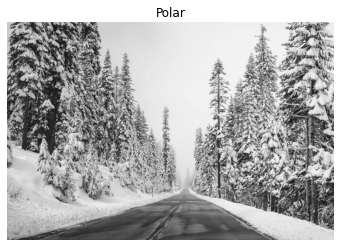

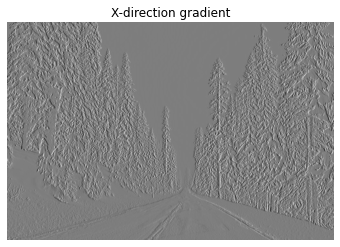

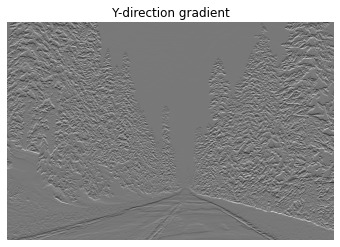

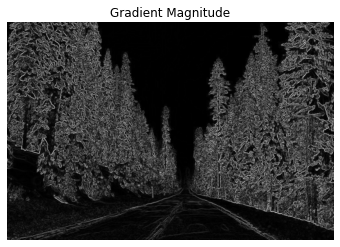

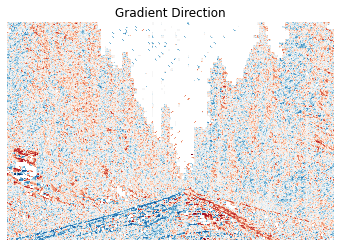

In [24]:
img = cv2.imread('./sample_data/sample_data/image2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (0, 0), fx=1, fy=1)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

Gx, Gy, magnt, direction = compute_gradient(img)
show_image(img)
show_image(Gx, "X-direction gradient")
show_image(Gy, "Y-direction gradient")
show_image(magnt, "Gradient Magnitude")
show_image(direction, "Gradient Direction", cmap='RdBu')

### 4.3.2 Second-order derivative filters

Compared to the Sobel filter, a Laplacian of Gaussian (LoG) relies on the second derivative of a Gaussian filter. Hence, it will focus on large gradients in the image. A LoG can be computed by the following three methods:



*   method 1: Smoothing the image with a Gaussian kernel (kernel size of 5 and standard deviation of 0.5), then taking the Laplacian of the smoothed image (i.e. second derivative).
*   method 2: Convolving the image directly with a LoG kernel (kernel size of 5 and standard deviation of 0.5).

*   method 3: Taking the Difference of two Gaussians (DoG) computed at different scales $\sigma_1$ and $\sigma_2$.





###Exercise 

Implement **compute_LoG**

The function should be able to apply any of the above mentioned methods depending on the value passed to the parameter *LOG_type*

**Note:** 
You are not allowed to use the Python built-in functions for computing LOG kernels. But for doing 2D convolution, you can benefit from *scipy.signal.convolve2d* function.

In [ ]:
def compute_LoG(image, LOG_type):

    if LOG_type == 1:
      #method 1
      """
      ================
      Your code here
      ================
      """

    elif LOG_type == 2:
      #method 2
      """
      ================
      Your code here
      ================
      """

    elif LOG_type == 3:
      #method 3
      """
      ================
      Your code here
      ================
      """

    return imOut

### Questions (10 pts)

1.   Test your function using image2.jpg and visualize your results using the three methods.





YOUR ANSWER HERE


2.   Discuss the difference between applying the three methods.


YOUR ANSWER HERE


3.   In the first method, why is it important to convolve an image with a Gaussian before convolving with a Laplacian?



YOUR ANSWER HERE

4.   In the third method, what is the best ratio between $\sigma_1$ and $\sigma_2$ to achieve the best approximation of the LoG? What is the purpose of having 2 standard deviations?



YOUR ANSWER HERE

5.   What else is needed to improve the performance and isolate the road,  i.e. what else should be done? You don't have to provide any specific parameter or specific algorithm. Try to propose a direction which would be interesting to explore and how you would approach it.


YOUR ANSWER HERE

## 4.4 Foreground-background separation

Foreground-background separation is an important task in the field of computer vision (see Figure). In this exercise, you will implement a simple unsupervised algorithm that leverages the variations in texture to segment the foreground object from the background. We will assume the foreground object has a distinct combination of textures compared to background. As mentioned earlier, Gabor filters are well-suited for texture analysis thanks to their frequency domain characteristics. Therefore, we will use a collection of Gabor filters with varying scale and orientations which we call a *filter bank*. The outline of the algorithm is as follows:

![](https://drive.google.com/uc?export=view&id=1w60xJ4UlG60Ie6ljRkHn0GJDdVu9eb5e)

**(Left)** Input image, **(Middle)** Foreground mask, **(Right)** Masked object. Foreground-Background separation aims at masking out the salient object pixels from the background pixels.

---

**Algorithm 1** Foreground-Background Segmentation Algorithm

---

**Input:** $x$ - input image

**Output:** $y$ - pixelwise labels



1.   Convert to grayscale if necessary.

>>**if** $x$ is RGB **then**

>>>$x$ $\leftarrow$ rgb2gray($x$)

>>**end if**

2.   Create Gabor filterbank, $\mathcal{F}_{gabor}$, with varying $\sigma$, $\lambda$ and $\theta$.

3.   Filter $x$ with the filterbank. Store each output in $fmaps$.

4.   Compute the magnitude of the complex $fmaps$. Store the results in $fmags$.

>>$fmags$ $\leftarrow$  $\vert fmaps \vert$

5.   Smooth $fmags$.

>>$fmags$ $\leftarrow$  smooth($fmags$)

6.   Convert $fmags$ into data matrix, $f$.

>>$f$ $\leftarrow$  reshape($fmags$)

7.   Cluster $f$ using kmeans into two sets.

>>$y$ $\leftarrow$  kmeans($f$, 2)

---


### Questions (20 pts)

1.   Run the algorithm on all test images with the provided parameter settings. What do you observe? Explain shortly.


YOUR ANSWER HERE


2.   Experiment with different $\lambda$, $\sigma$ and $\theta$ settings until you get reasonable outputs. Report what parameter settings work better for each input image and try to explain why.

>**Hint:** 
Don't change multiple variables at once. You might not need to change some at all.



YOUR ANSWER HERE

3.   After you achieve good separation on all test images, run the script again with corresponding parameters but this time with

>>>smoothingFlag = False

>Describe what you observe at the output when smoothing is not applied on the magnitude images. Explain why it happens and try to reason about the motivation behind this step.

YOUR ANSWER HERE

###Exercise

Please get yourself familiar with provided skeleton code **gabor_segmentation**.py. Keep in mind that you will need your implementation of the **createGabor** function.

When you succesfully implement it all, it should run without problems and produce a reasonable segmentation with the default parameters on **kobi.png**.

In [ ]:
image_id = "Polar"
img = load_image(image_id) # load an image with the Polar bear

show_image(img, f'Input image: {image_id}')


In [ ]:

# Control settings
visFlag       = False    #  Set to true to visualize filter responses.
smoothingFlag = True   #  Set to true to postprocess filter outputs.

# Design array of Gabor Filters
# In this code section, you will create a Gabor Filterbank. A filterbank is
# a collection of filters with varying properties (e.g. {shape, texture}).
# A Gabor filterbank consists of Gabor filters of distinct orientations
# and scales. We will use this bank to extract texture information from the
# input image. 

numRows, numCols = img.shape

# Estimate the minimum and maximum of the wavelengths for the sinusoidal
# carriers. 
# ** This step is pretty much standard, therefore, you don't have to
#    worry about it. It is cycles in pixels. **   
lambdaMin = 4/np.sqrt(2)
lambdaMax = np.sqrt(abs(numRows)**2 + abs(numCols)**2)

# Specify the carrier wavelengths.  
# (or the central frequency of the carrier signal, which is 1/lambda)
n = np.floor(np.log2(lambdaMax/lambdaMin))
lambdas = 2**np.arange(0, (n-2)+1) * lambdaMin

# Define the set of orientations for the Gaussian envelope.
dTheta       = 2 * np.pi/8                  # \\ the step size
orientations = np.arange(0, np.pi+dTheta, dTheta)        

# Define the set of sigmas for the Gaussian envelope. Sigma here defines 
# the standard deviation, or the spread of the Gaussian. 
sigmas = np.array([1,2])

# Now you can create the filterbank. We provide you with a Python list
# called gaborFilterBank in which we will hold the filters and their
# corresponding parameters such as sigma, lambda and etc. 
# ** All you need to do is to implement createGabor(). Rest will be handled
#    by the provided code block. **
gaborFilterBank = []
tic = time.time()
for lmbda in lambdas:
    for sigma in sigmas:
        for theta in orientations:
            # Filter parameter configuration for this filter.
            psi    = 0
            gamma  = 0.5
            
            # Create a Gabor filter with the specs above. 
            # (We also record the settings in which they are created. )
            # // TODO: Implement the function createGabor() following
            #          the guidelines in the given function template.
            #          ** See createGabor.py for instructions ** //
            filter_config = {}
            filter_config["filterPairs"] = createGabor( sigma, theta, lmbda, psi, gamma )
            filter_config["sigma"]       = sigma
            filter_config["lmbda"]       = lmbda
            filter_config["theta"]       = theta
            filter_config["psi"]         = psi
            filter_config["gamma"]       = gamma
            gaborFilterBank.append(filter_config)
ctime = time.time() - tic

print('--------------------------------------\n \t\tDetails\n--------------------------------------')
print(f'Total number of filters       : {len(gaborFilterBank)}')
print(f'Number of scales (sigma)      : {len(sigmas)}')
print(f'Number of orientations (theta): {len(orientations)}')
print(f'Number of carriers (lambda)   : {len(lambdas)}')
print(f'---------------------------------------')
print(f'Filter bank created in {ctime} seconds.')
print(f'---------------------------------------')

# Filter images using Gabor filter bank using quadrature pairs (real and imaginary parts)
# You will now filter the input image with each complex Gabor filter in 
# gaborFilterBank structure and store the output in the cell called 
# featureMaps. 
# // Hint-1: Apply both the real imaginary parts of each kernel 
#            separately in the spatial domain (i.e. over the image). //
# // Hint-2: Assign each output (i.e. real and imaginary parts) in
#            variables called real_out and imag_out. //
# // Hint-3: Use built-in cv2 function, filter2D, to convolve the filter
#            with the input image. Check the options for padding. Find 
#            the one that works well. You might want to
#            explain what works better and why shortly in the report.
featureMaps = []

for gaborFilter in gaborFilterBank:
    # gaborFilter["filterPairs"] has two elements. One is related to the real part 
    # of the Gabor Filter and the other one is the imagineray part.
    real_out = None  # \\TODO: filter the grayscale input with real part of the Gabor
    imag_out = None  # \\TODO: filter the grayscale input with imaginary part of the Gabor
    featureMaps.append(np.stack((real_out, imag_out), 2))
    
    # Visualize the filter responses if you wish.
    if visFlag:
        fig = plt.figure()

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(real_out)    # Real
        title = "Re[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilter["lmbda"], gaborFilter["theta"], gaborFilter["sigma"])
        ax.set_title(title)
        ax.axis("off")

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(imag_out)    # Real
        title = "Im[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilter["lmbda"], gaborFilter["theta"], gaborFilter["sigma"])
        ax.set_title(title)
        ax.axis("off")
        plt.show()

# Compute the magnitude
# Now, you will compute the magnitude of the output responses.
# \\ Hint: (real_part^2 + imaginary_part^2)^(1/2) \\
featureMags = []
for i, fm in enumerate(featureMaps):
    real_part = fm[...,0]
    imag_part = fm[...,1]
    mag = None  # \\TODO: Compute the magnitude here
    featureMags.append(mag)
    
    # Visualize the magnitude response if you wish.
    if visFlag:
        fig = plt.figure()

        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(mag.astype(np.uint8))    # visualize magnitude
        title = "Re[h(x,y)], \n lambda = {0:.4f}, \n theta = {1:.4f}, \n sigma = {2:.4f}".format(gaborFilterBank[i]["lmbda"], 
                                                                                                 gaborFilterBank[i]["theta"], 
                                                                                                 gaborFilterBank[i]["sigma"])
        ax.set_title(title)
        ax.axis("off")

# Prepare and Preprocess features 
# You can think of each filter response as a sort of feature representation
# for the pixels. Now that you have numFilters = |gaborFilterBank| filters, 
# we can represent each pixel by this many features. 
# \\ Q: What kind of features do you think gabor filters might correspond to? 

# You will now implement a smoothing operation over the magnitude images in
# featureMags. 
# \\ Hint: For each i in [1, length(featureMags)], smooth featureMags{i}
#          using an appropriate first order Gaussian kernel.
# \\ Hint: cv2 filter2D function is helpful here.   
features = np.zeros(shape=(numRows, numCols, len(featureMags)))
if smoothingFlag:
    pass
    # \\TODO:
    #FOR_LOOP
        # i)  filter the magnitude response with appropriate Gaussian kernels
        # ii) insert the smoothed image into features[:,:,j]
    #END_FOR
else:
    # Don't smooth but just insert magnitude images into the matrix
    # called features.
    for i, fmag in enumerate(featureMags):
        features[:,:,i] = fmag


# Reshape the filter outputs (i.e. tensor called features) of size 
# [numRows, numCols, numFilters] into a matrix of size [numRows*numCols, numFilters]
# This will constitute our data matrix which represents each pixel in the 
# input image with numFilters features.  
features = np.reshape(features, newshape=(numRows * numCols, -1))


# Standardize features. 
# \\ Hint: see http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing for more information.

features = None  # \\ TODO: i)  Implement standardization on matrix called features.
                 #          ii) Return the standardized data matrix.


# (Optional) Visualize the saliency map using the first principal component 
# of the features matrix. It will be useful to diagnose possible problems 
# with the pipeline and filterbank.

transformed_feature = PCA(n_components=1).fit_transform(features) # select the first component
transformed_feature = np.ascontiguousarray(transformed_feature, dtype=np.float32)
feature2DImage = np.reshape(transformed_feature,newshape=(numRows,numCols))
plt.figure()
plt.title(f'Pixel representation projected onto first PC')
plt.imshow(feature2DImage, cmap='gray')
plt.axis("off") 
plt.show()

# Apply k-means algorithm to cluster pixels using the data matrix,
# features. 
# \\ Hint-1: search about sklearn kmeans function https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html.
# \\ Hint-2: use the parameter k defined in the first section when calling
#            sklearn's built-in kmeans function.
tic = time.time()
pixLabels = None  # \\TODO: Return cluster labels per pixel
ctime = time.time() - tic
print(f'Clustering completed in {ctime} seconds.')



# Visualize the clustering by reshaping pixLabels into original grayscale
# input size [numRows numCols].
pixLabels = np.reshape(pixLabels, newshape=(numRows, numCols))
plt.figure()
plt.title(f'Pixel clusters')
plt.imshow(pixLabels)
plt.axis("off") 
plt.show()


# Use the pixLabels to visualize segmentation.
Aseg1 = np.zeros_like(img)
Aseg2 = np.zeros_like(img)
BW = pixLabels == 2  # check for the value of your labels in pixLabels (could be 1 or 0 instead of 2)
BW = np.repeat(BW[:, :, np.newaxis], 3, axis=2) # do this only if you have 3 channels in the img
Aseg1[BW] = img[BW]
Aseg2[~BW] = img[~BW]

plt.figure()
plt.title(f'montage')
plt.imshow(Aseg1, 'gray', interpolation='none')
plt.imshow(Aseg2, 'jet',  interpolation='none', alpha=0.7)
plt.axis("off")
plt.show()